# Making NJ trees

Imports.

In [1]:
import Bio # calculating tree structure
import numpy as np # data management
import toytree # clean high-level interface for visualizing trees
import toyplot # underlying plotting library

import genotype_helpers # genotype processing
import io_helpers # file I/O

# these functions must be imported specially
import toyplot.svg
import toyplot.png

print(f'''
This notebook adds:
Biopython version {Bio.__version__},
toyplot version {toyplot.__version__},
toytree version {toytree.__version__}
''')


This I/O helper file uses:
Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)],
Matplotlib version 3.7.1,
pandas version 1.5.3


This genotype helper file adds:
NumPy version 1.24.3,
pyMSAviz version 0.4.0,
scikit-allel version 1.3.6


This notebook adds:
Biopython version 1.81,
toyplot version 1.0.3,
toytree version 2.0.1



Constant.

In [2]:
tree_constructor = Bio.Phylo.TreeConstruction.DistanceTreeConstructor()

Helper functions. Note that `save_plot` had to rewritten to work with `toyplot`
instead of `Matplotlib`, though the API was kept. Since `toyplot` is only used 
in this notebook (out of necessity for `toytree`) the modified function is 
stored here instead of `plotting_helpers.py`.

In [3]:
def hamming_ignore_missing(x: np.ndarray, y: np.ndarray) -> float:
    """Calculate Hamming distance while ignoring missing data."""
    nonmiss = np.logical_and(~np.isnan(x), ~np.isnan(y))
    return np.not_equal(x[nonmiss], y[nonmiss]).sum() / nonmiss.sum()

def vcf_to_tree(vcf_file: str, chrom: str, basename: str) -> toytree.tree:
    """Create a tree object for plotting by applying NJ to genotypes.

    Parameters
    ----------
    vcf_file: str
        VCF file to read data from. 
    chrom: str
        Chromosome to read data for; either "Y" or "MT".
    basename : str
        Basename of file to save NEWICK to; no directory or extension.

    Returns
    -------
    tree: toytree.tree
        Tree object ready for plotting by toytree.
    """

    geno = genotype_helpers.get_genotypes(vcf_file, chrom, format='allele_num')

    # lower triangle + main diagonal of a pairwise distance matrix
    lower_triangle = [[hamming_ignore_missing(geno.iloc[i], geno.iloc[j]) 
                       for j in range(0, i + 1)] for i in range(geno.shape[0])]
    
    biopy_dm = Bio.Phylo.TreeConstruction.DistanceMatrix(
        geno.index.to_list(), lower_triangle
        )
    biopy_tree = tree_constructor.nj(biopy_dm)

    newick_file = io_helpers.file_path('results', 'trees', f'{basename}.tree')
    Bio.Phylo.write(biopy_tree, newick_file, 'newick')
    return toytree.tree(newick_file, tree_format=1)
    
def toyplot_save_plot(basename: str, figure: toyplot.Canvas, 
                      extension: str) -> None:
    """Save a toyplot Canvas into `results/plots/`."""
    file = io_helpers.file_path('results', 'plots', f'{basename}.{extension}')
    if extension == 'svg': toyplot.svg.render(figure, file)
    elif extension == 'png': toyplot.png.render(figure, file)

Make NJ trees.

Read 18499 variants across 8 samples
0 samples removed for not being male
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 9083 variants for MAF=0
Filtering out 710 variants for % nonmissing calls < 75
Filtering out 0 samples for % nonmissing calls < 50
Genotypes for 8 rats across 8706 variants


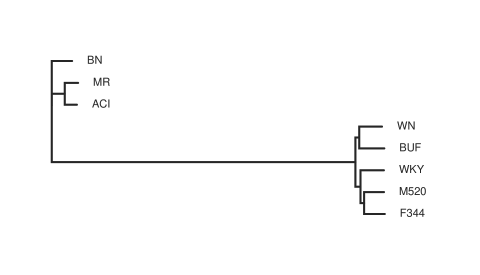

In [4]:
# Figure 1A
y_founder_tree = vcf_to_tree(
    genotype_helpers.FOUNDERS_FILE, chrom='Y', basename='y_founders'
    # swap positions of groups to match with 1D
    ).root(['ACI', 'BN', 'MR']).unroot()

canvas, axes, _ = y_founder_tree.draw(width='5in')

toyplot_save_plot('Y_founders_tree', canvas, extension='svg')

canvas

Read 122 variants across 8 samples
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 1 variants for MAF=0
Filtering out 0 variants for % nonmissing calls < 75
Filtering out 0 samples for % nonmissing calls < 50
Genotypes for 8 rats across 121 variants


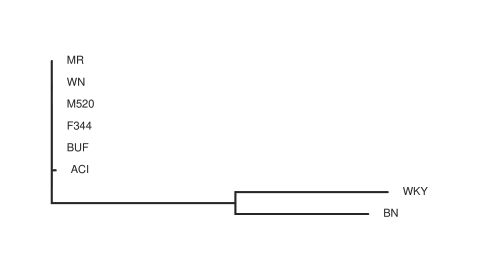

In [5]:
# Figure 2A
mt_founder_tree = vcf_to_tree(
    genotype_helpers.FOUNDERS_FILE, chrom='MT', basename='MT_founders'
    )

canvas, axes, _ = mt_founder_tree.draw(width='5in')

toyplot_save_plot('MT_founders_tree', canvas, extension='svg')

canvas

Read 4165 variants across 96 samples
44 samples removed for not being male
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 2564 variants for MAF=0
Filtering out 1004 variants for % nonmissing calls < 75
Filtering out 0 samples for % nonmissing calls < 50
Genotypes for 52 rats across 597 variants


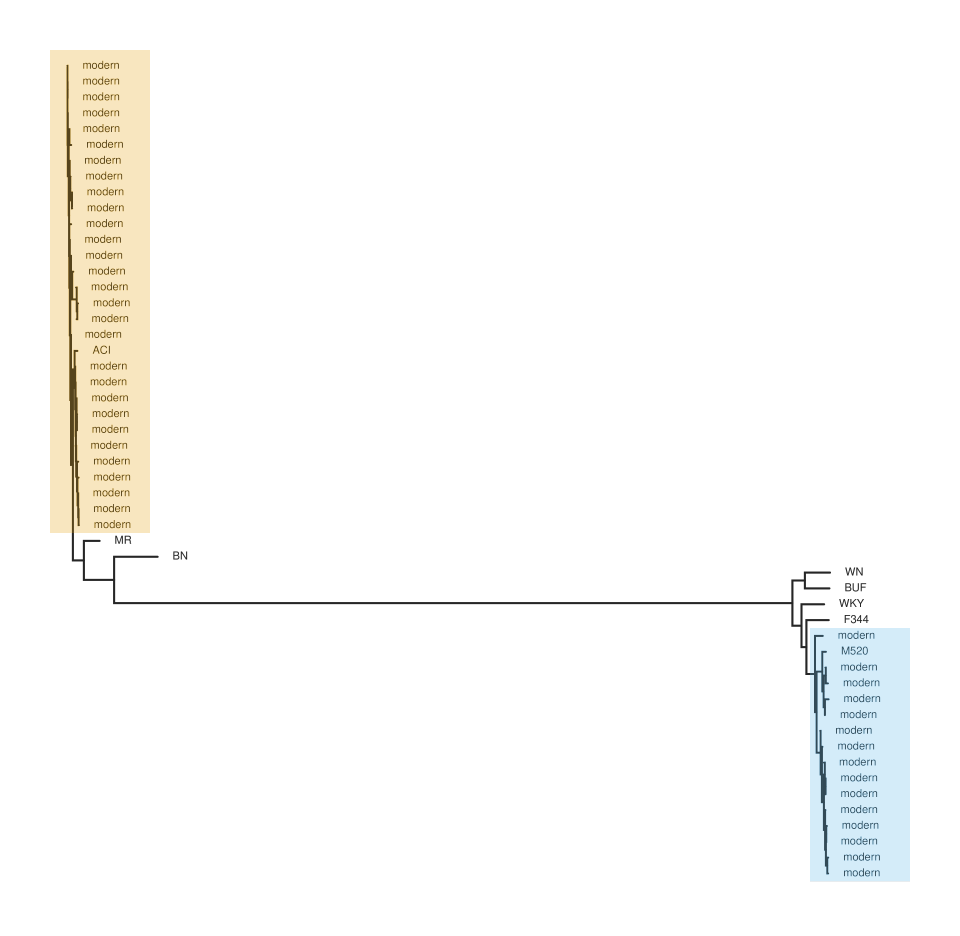

In [6]:
# Figure S5
str_tree = vcf_to_tree(genotype_helpers.STR_FILE, chrom='Y', basename='STRs')

# modern RFIDs are unimportant; make them uniform so that founders stand out
sample_names = [name if name in genotype_helpers.FOUNDER_NAMES else 'modern' 
                for name in str_tree.get_tip_labels()]
canvas, axes, _ = str_tree.draw(tip_labels=sample_names, width='10in')

# highlight Y1 and Y2 clades to emphasize founder MRCAs
axes.rectangle(-0.975, -0.85, 21.5, 52, opacity=0.25, 
               color=io_helpers.COLORBLIND_PALETTE[2])
axes.rectangle(-0.025, 0.1, -0.5, 15.5, opacity=0.25, 
               color=io_helpers.COLORBLIND_PALETTE[3])

toyplot_save_plot('Y_STR_tree', canvas, extension='png')

canvas